
# TP CNN, part 3 : super-resolution

Author : Alasdair Newson
alasdair.newson@telecom-paris.fr
 
## Objective:

We want to implement a Convolutional Neural Network (CNN) to do image super-resolution.

## Image super-resolution:

The super-resolution problem can be summarised as follows. We have an image as an input, which is defined over a grid $\{0,1,\dots, m-1\} \times \{0,1,\dots, n-1\}$. We define a factor $\delta$, by which we upsample the image. The output of the super-resolution is an image defined on the grid $\{0,\frac{1}{\delta},\dots, m-1\} \times \{0,\frac{1}{\delta},\dots, n-1\}$.

## Model

In this part of the TP, you have complete freedom to create any model you want, as long as the input is an image, and the output is also an image of size $\delta m \times \delta n$. You will have to choose the architecture and loss which seems reasonable to you.

To help you, here is a function to upsample images in neural networks :

- ```from tensorflow.keras.layers import UpSampling2D```

Of course, you can use any upsampling layer you wish. 

## Dataset

We will be using the mnist dataset for this part. This is to ensure that you can obtain good results. The input data should be the subsampled version of the mnist images, subsampled by taking one out of every $\delta$ pixels. The output data should be the normal-resolution mnist images.

__IMPORTANT NOTES:__
- Think carefully about what the training data and labels are in this case, and create them accordingly
- We will use ```n_max=5000``` to limit the number of datapoints (as in part 1) to go faster
- We set $\delta$ to 2 in this TP, because it is not too difficult to create a network that works with this factor. If you change it, it might be more difficult to create a satisfactory network.

# Your task:
You have to load the mnist data (see the first part of the TP), create the model, train it, and evaluate and display the results.

We have created a function ```super_res_interpolate```, which carries out super-resolution using basic interpolation (bilinear or bicubic), with which you can compare your results visually and numerically.



In [45]:

# # Load packages

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, AveragePooling2D, Add
from tensorflow.keras import optimizers
from scipy import interpolate
print(tf.keras.__version__)

2.2.4-tf


This next cell is the only code you are given to carry out the TP. This function carries out a bilinear upsampling, with which you can compare your super-resolution. This function is __not__ supposed to be used by you in your network.

In [2]:
# choice of the interpolation method
interp_method = 'linear'
# upsampling factor
delta = 2
# the maximum number of data to take from mnist (to go a bit faster)
n_max = 5000

# upsample by a factor of delta
# by definition, the new grid has a step size of 1/delta
def super_res_interpolate(imgs_in,delta,interp_method = 'linear'):
    imgs_out = tf.image.resize( tf.constant(imgs_in),\
        [delta*imgs_in.shape[1],delta*imgs_in.shape[2]], method='bilinear').numpy()

    return(imgs_out)


## Create your super-resolution network

The rest is up to you ! Import the data, format it (you can use the first part of the TP as help), create your network, train it, and compare the results with ```super_res_interpolate```.

Your network should be able to achieve about $80\%$ accuracy.

__Note__ you can obviously create as many cells as you like in your work.

### 1. Import MNIST and subsample images:

In [3]:
from keras.datasets import mnist
(X_train, Y_train_scalar), (X_test, Y_test_scalar) = mnist.load_data()

X_train = X_train[0:n_max,:,:]
X_test = X_test[0:n_max,:,:]
# Y_train_scalar = Y_train_scalar[0:n_max]
# Y_test_scalar = Y_test_scalar[0:n_max]

mnist_label_list = ['0','1','2','3','4','5','6','7','8','9']

# input image dimensions (mnist data is grey-level)
img_rows, img_cols, nb_channels = X_train.shape[1], X_train.shape[2], 1

# In case depth is 1 (black and white pictures) -> reshape to proper format
X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, nb_channels)
X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, nb_channels)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

# Y_train = to_categorical(Y_train_scalar)
# Y_test = to_categorical(Y_test_scalar)

# number of classes
# nb_classes = Y_train.shape[1]

In [9]:
a=np.array([1,2,3,4,5,6])
a[0:-1:2]

array([1, 3, 5])

In [24]:
x_train = np.zeros((n_max, int(img_rows/delta), int(img_cols/delta), nb_channels))
for i, x in enumerate(X_train):
    x_train[i] = x[0:-1:delta, 0:-1:delta, :]
    
x_test = np.zeros((n_max, int(img_rows/delta), int(img_cols/delta), nb_channels))
for i, x in enumerate(X_test):
    x_test[i] = x[0:-1:delta, 0:-1:delta, :]

Text(0.5, 1.0, 'Subsampled resolution (input to be)')

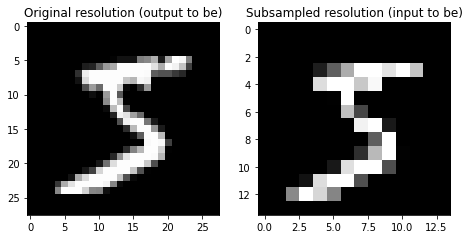

In [20]:
idx = 0
plt.figure(figsize=(20, 12))

plt.subplot(2, 5, 1)
plt.imshow(X_train[idx,:,:],cmap='gray')
plt.title("Original resolution (output to be)")


plt.subplot(2, 5, 2)
plt.imshow(x_train[idx],cmap='gray')
plt.title("Subsampled resolution (input to be)")


### 2. CNN model:

In [47]:
learning_rate = 0.01
n_epochs = 10
batch_size = 64

# number of convolutional filters to use
nb_filters = 1 #32
# convolution kernel size
kernel_size = (3, 3)
# size of pooling area for max pooling
# pool_size = (2, 2)

# --- Size of the successive layers
n_h_0 = nb_channels  # number of input channels
n_h_1 = nb_filters
# n_h_2 = nb_filters

#input image size
img_size = (int(img_rows/delta), int(img_cols/delta), n_h_0)

model = Sequential()

model.add(Conv2D(filters=n_h_1,
                 kernel_size=kernel_size,
                 input_shape=img_size,
                 strides=(1,1),
                 padding='same',
                 activation='relu',
                 name='Conv1'))

# model.add(Conv2D(filters=n_h_2,
#                  kernel_size=kernel_size,
#                  strides=(1,1),
#                  padding='same',
#                  activation='relu',
#                  name='Conv2'))

model.add(UpSampling2D(size=(2,2)))
# model.add(Reshape((img_rows, img_cols, n_h_0)))
# model.add(Add())

model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv1 (Conv2D)               (None, 14, 14, 1)         10        
_________________________________________________________________
up_sampling2d_7 (UpSampling2 (None, 28, 28, 1)         0         
Total params: 10
Trainable params: 10
Non-trainable params: 0
_________________________________________________________________


### 3. Training and accuracy:

In [48]:
def deep_dream_loss(model_in,img_in):
    activation = model_in(img_in) 
    if len(activation) == 1:
        activation = [activation]

    losses = []
    for act in activation:
        loss = tf.math.reduce_mean(act)
        losses.append(loss)
    total_loss = tf.math.reduce_sum(losses)

    return total_loss

In [49]:
model.compile(optimizer=optimizers.Adam(learning_rate=learning_rate), loss= "mse", metrics=['accuracy'])
model.fit(x_train, X_train, epochs=n_epochs, batch_size=batch_size)

score = model.evaluate(x_test, X_test, verbose=False)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 5000 samples
Epoch 1/10
5000/5000 [==============================] - 1s 249us/sample - loss: 0.0793 - accuracy: 0.7984
Epoch 2/10
5000/5000 [==============================] - 0s 53us/sample - loss: 0.0221 - accuracy: 0.8094
Epoch 3/10
5000/5000 [==============================] - 0s 47us/sample - loss: 0.0207 - accuracy: 0.8098
Epoch 4/10
5000/5000 [==============================] - 0s 48us/sample - loss: 0.0207 - accuracy: 0.8098
Epoch 5/10
5000/5000 [==============================] - 0s 44us/sample - loss: 0.0207 - accuracy: 0.8098
Epoch 6/10
5000/5000 [==============================] - 0s 42us/sample - loss: 0.0207 - accuracy: 0.8098
Epoch 7/10
5000/5000 [==============================] - 0s 40us/sample - loss: 0.0207 - accuracy: 0.8098
Epoch 8/10
5000/5000 [==============================] - 0s 42us/sample - loss: 0.0207 - accuracy: 0.8098
Epoch 9/10
5000/5000 [==============================] - 0s 41us/sample - loss: 0.0207 - accuracy: 0.8098
Epoch 10/10
5000/5000 [=========

### 4. Comparison:

In [55]:
imgs_in = x_train[:5]
my_imgs_out = model(imgs_in)
orig = X_train[:5]

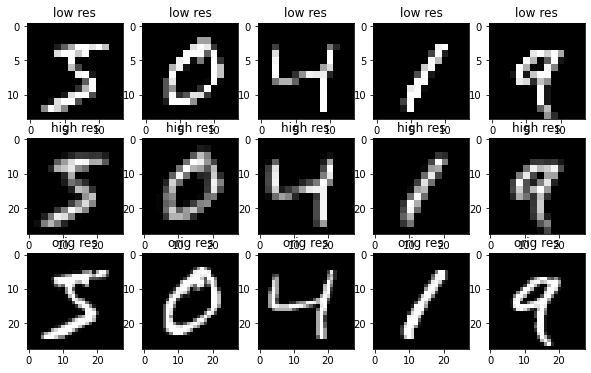

In [56]:
plt.figure(figsize=(10, 6))
for idx in range(0,5):
    plt.subplot(3, 5, idx+1)
    plt.imshow(imgs_in[idx,:,:],cmap='gray')
    plt.title("low res")
for idx in range(5,10):
    plt.subplot(3, 5, idx+1)
    plt.imshow(my_imgs_out[idx-5,:,:],cmap='gray')
    plt.title("high res")
for idx in range(10,15):
    plt.subplot(3, 5, idx+1)
    plt.imshow(orig[idx-10,:,:],cmap='gray')
    plt.title("orig res")

In [32]:
imgs_out = super_res_interpolate(imgs_in, delta)

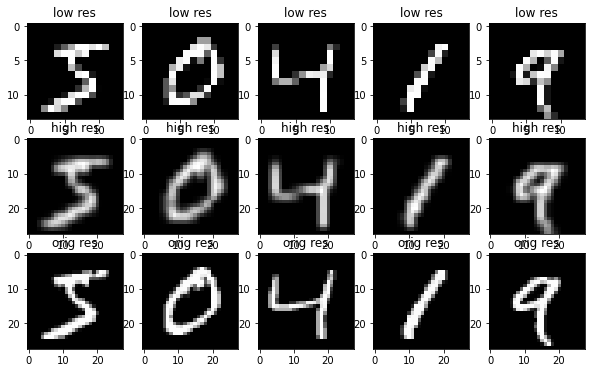

In [34]:
plt.figure(figsize=(10, 6))
for idx in range(0,5):
    plt.subplot(3, 5, idx+1)
    plt.imshow(imgs_in[idx,:,:],cmap='gray')
    plt.title("low res")
for idx in range(5,10):
    plt.subplot(3, 5, idx+1)
    plt.imshow(imgs_out[idx-5,:,:],cmap='gray')
    plt.title("high res")
for idx in range(10,15):
    plt.subplot(3, 5, idx+1)
    plt.imshow(orig[idx-10,:,:],cmap='gray')
    plt.title("orig res")

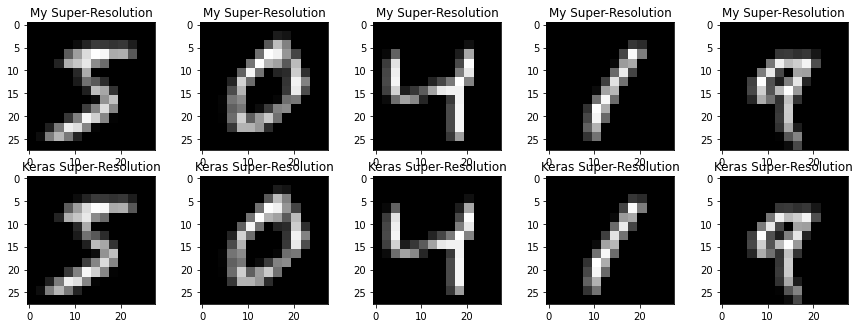

In [60]:
plt.figure(figsize=(15, 8))
for idx in range(0,5):
    plt.subplot(3, 5, idx+1)
    plt.imshow(my_imgs_out[idx,:,:],cmap='gray')
    plt.title("My Super-Resolution")
for idx in range(5,10):
    plt.subplot(3, 5, idx+1)
    plt.imshow(imgs_out[idx-5,:,:],cmap='gray')
    plt.title("Keras Super-Resolution")

The results are very competitive, we can consider it as a success!

# Evaluation

To evaluate the work, you should rate the code for 
- 1) Importing MNIST correctly (correctly formatting the data) : 1 point
- 2) Creating a model which makes sense (correct input/output sizes) : 1 point
- 3) Training and achieving good results  : 2 points. 1 point if the learning increases but does not reach around $80\%$, 2 points if the learning reaches around $80\%$
- 4) Display a visual comparison of your network with ```super_res_interpolate``` for several examples

Total over 5 points.
